In [2]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = r'\usepackage{libertine}\usepackage{fixltx2e}'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.linewidth'] = 0.2
plt.rcParams['hist.bins'] = 'auto'
plt.rcParams['font.size'] = 8
colors = plt.get_cmap('tab10').colors

from dataproc.data import cartesian

def load_results(basename, buckets=1):
    return pd.concat([
        pq.read_table(f'{basename}#{shard}.results-{buckets}').to_pandas()
        for shard in range(199)
    ])

def load_shard_titles(shard_dir):
    return pd.concat([
        (pd.read_csv('{}/{:0>3d}'.format(shard_dir, shard), names=['title'])
         .assign(shard=shard)
         .assign(shard_size=lambda df: len(df))
         .rename_axis('ldocid')
         .reset_index())
        for shard in range(199)
    ])

def load_documents(titles_file, title_dir):
    titles = pd.read_csv(titles_file, names=['title'])
    titles.index.name = 'docid'
    titles.reset_index(inplace=True)
    shard_titles = load_shard_titles(title_dir)
    shard_titles['depth'] = shard_titles['ldocid'] / shard_titles['shard_size']
    return pd.merge(titles, shard_titles, on='title', how='left')

def load_posting_costs(basename, buckets=1):
    return pd.concat([
        pq.read_table(f'{basename}#{shard}.postingcost-{buckets}').to_pandas()
        for shard in range(199)
    ])

def calc_taily_features(taily_scores):
    tf = taily_scores.copy()
    tf['rank'] = tf.groupby('query').rank(method='first', ascending=False)['taily']
    tf['invrank'] = 1 / tf['rank']
    tf['binrank'] = np.ceil(tf['rank'] / 10)
    return tf

feature_dir = '/data/michal/experiments/oss/gov2-dai/features/trec'

# Preprocess Data

In [2]:
documents = load_documents(titles_file='/data/index/dai-gov2/full/gov2.titles',
                           title_dir='/data/index/dai-gov2/shards/titles')
# pq.write_table(pa.Table.from_pandas(documents),

In [3]:
qrels = pd.read_csv('/data/queries/gov2/gov2-qrels.txt', names=['trecid', '_', 'title', 'relevance'], sep=' ')
qrels['query'] = qrels['trecid'] - 701
qrels['relevant'] = qrels['relevance'] > 0
qrels = qrels[['query', 'trecid', 'title', 'relevance', 'relevant']]
qrels.to_csv('/data/queries/gov2/gov2-qrels.csv')

# Ground Truth

## Shard-wise

In [4]:
gt_fast = pd.merge(qrels, documents, on='title').groupby(['query', 'shard']).agg({'relevant': 'sum'})
gt_fast.reset_index(inplace=True)
gt_fast = pd.merge(gt_fast, cartesian([range(150), range(199)], names=['query', 'shard']),
                   on=['query', 'shard'], how='right').fillna(0)
gt_fast.rename(columns={'relevant': 'shard_score'}, inplace=True)
gt_fast['rank'] = gt_fast.groupby(['query']).rank(method='first', ascending=False)['shard_score']
gt_fast.to_csv(f'{feature_dir}/ground_truth.csv', index=False)

## B = 10

In [5]:
gt_b10 = (pd.merge(qrels, documents, on='title')
          .assign(bucket=lambda df: np.floor(df['depth'].multiply(10)).astype(np.int))
          .groupby(['query', 'shard', 'bucket'])
          .agg({'relevant': 'sum'}))
gt_b10.reset_index(inplace=True)
gt_b10 = pd.merge(gt_b10, cartesian([range(150), range(199), range(10)],
                                    names=['query', 'shard', 'bucket']),
                  on=['query', 'shard', 'bucket'], how='right').fillna(0)
gt_b10.rename(columns={'relevant': 'shard_score'}, inplace=True)
gt_b10['rank'] = gt_b10.groupby(['query']).rank(method='first', ascending=False)['shard_score']
gt_b10.to_csv(f'{feature_dir}/ground_truth_b10.csv', index=False)

## B = 20

In [6]:
gt_b20 = (pd.merge(qrels, documents, on='title')
          .assign(bucket=lambda df: np.floor(df['depth'].multiply(20)).astype(np.int))
          .groupby(['query', 'shard', 'bucket'])
          .agg({'relevant': 'sum'}))
gt_b20.reset_index(inplace=True)
gt_b20 = pd.merge(gt_b20, cartesian([range(150), range(199), range(20)],
                                    names=['query', 'shard', 'bucket']),
                  on=['query', 'shard', 'bucket'], how='right').fillna(0)
gt_b20.rename(columns={'relevant': 'shard_score'}, inplace=True)
gt_b20['rank'] = gt_b20.groupby(['query']).rank(method='first', ascending=False)['shard_score']
gt_b20.to_csv(f'{feature_dir}/ground_truth_b20.csv', index=False)

In [6]:
gt_b20.groupby('bucket').mean()

,query,shard,shard_score,rank
bucket,,,,
0,74.5,99.0,0.133199,1825.525829
1,74.5,99.0,0.107638,1883.091926
2,74.5,99.0,0.082144,1911.265226
3,74.5,99.0,0.076985,1927.913032
4,74.5,99.0,0.074003,1935.003987
5,74.5,99.0,0.071022,1941.862178
6,74.5,99.0,0.063886,1952.040201
7,74.5,99.0,0.051122,1971.276348
8,74.5,99.0,0.046097,1979.215410


# Shard Popularity

In [11]:
popularity = (pd.merge(qrels[qrels['relevant'] == True], documents, on='title')
 .groupby('shard')['relevant']
 .agg([('popularity', 'count')])
 .reset_index())
shard_popularity = pd.merge(pd.DataFrame({'shard': range(199)}),
                            popularity, on='shard', how='left').fillna(0)
shard_popularity.astype('int')
shard_popularity.to_csv(f'{feature_dir}/shard_popularity.csv', index=False)

# Term Based Features

## Taily

In [12]:
taily = pq.read_table(f'{feature_dir}/gov2-trec_eval-queries-OR.txt.taily').to_pandas()
taily_features = calc_taily_features(taily)
taily_features.to_csv(f'{feature_dir}/taily_features.csv', index=False)

## Champion List Features

In [13]:
champion_lists = pd.read_csv(f'{feature_dir}/champion-lists.csv')

## Query Likelihood

In [14]:
ql_body = pd.read_csv(f'{feature_dir}/query-likelihood.text.csv')
ql_title = pd.read_csv(f'{feature_dir}/query-likelihood.title.csv')
ql_anchor = pd.read_csv(f'{feature_dir}/query-likelihood.anchor.csv')
ql = pd.merge(ql_body, ql_title, on=['query', 'shard'], suffixes=['', '-title'])
ql = pd.merge(ql, ql_anchor, on=['query', 'shard'], suffixes=['-body', '-anchor'])

## Query Term Statistics

In [15]:
qts_body = pd.read_csv(f'{feature_dir}/query-term-stats.text.csv')
qts_title = pd.read_csv(f'{feature_dir}/query-term-stats.title.csv')
qts_anchor = pd.read_csv(f'{feature_dir}/query-term-stats.anchor.csv')
qts = pd.merge(qts_body, qts_title, on=['query', 'shard'], suffixes=['', '-title'])
qts = pd.merge(qts, qts_anchor, on=['query', 'shard'], suffixes=['-body', '-anchor'])

## Bigram Log Frequency

In [16]:
bilogfq = pd.read_csv(f'{feature_dir}/bigram-log-frequency.text.csv')

# Cost Models

## Shard Size Cost

In [28]:
shard_size_costs = pd.read_csv('/data/index/dai-gov2/shard-sizes.csv')
shard_size_costs['cost'] = shard_size_costs['shard_size'] * 100 / shard_size_costs['shard_size'].sum()
shard_size_costs.drop(columns=['shard_size']).to_csv(f'{feature_dir}/shard-size-costs.csv', index=False)

## Posting Cost

### B = 1

In [43]:
shard_posting_costs = load_posting_costs(f'{feature_dir}/gov2-trec_eval-queries-OR.txt')
shard_posting_costs['cost'] = shard_posting_costs['postingcost'] / 1000
shard_posting_costs['query'] += 701
shard_posting_costs[['query', 'shard', 'cost']].to_csv(f'{feature_dir}/shard-posting-costs.csv', index=False)

# # %
# shard_posting_costs = load_posting_costs(f'{feature_dir}/gov2-trec_eval-queries-OR.txt')
# def f(x):
#     total = x['postingcost'].sum()
#     df = pd.DataFrame({
#         'shard': x['shard'],
#         'cost': x['postingcost'] * 100 / total
#     })
#     return df.reset_index(drop=True)
# shard_posting_costs = shard_posting_costs.groupby('query').apply(f).reset_index(level='query')
# shard_posting_costs['query'] += 701
# shard_posting_costs[['query', 'shard', 'cost']].to_csv(f'{feature_dir}/shard-posting-costs-frac.csv', index=False)

# del shard_posting_costs
shard_posting_costs.groupby('query').sum().mean()

shard          1.970100e+04
bucket         0.000000e+00
postingcost    5.852161e+06
cost           5.852161e+03
dtype: float64

### B = 10

In [8]:
shard_posting_costs = load_posting_costs(f'{feature_dir}/gov2-trec_eval-queries-OR.txt', buckets=10)
shard_posting_costs['cost'] = shard_posting_costs['postingcost'] / 1000
shard_posting_costs['query'] += 701
shard_posting_costs[['query', 'shard', 'bucket', 'cost']].to_csv(f'{feature_dir}/shard-posting-costs-b10.csv', index=False)

shard_posting_costs = load_posting_costs(f'{feature_dir}/gov2-trec_eval-queries-OR.txt', buckets=10)
def f(x):
    total = x['postingcost'].sum()
    df = pd.DataFrame({
        'shard': x['shard'],
        'bucket': x['bucket'],
        'cost': x['postingcost'] * 100 / total
    })
    return df.reset_index(drop=True)
shard_posting_costs = shard_posting_costs.groupby('query').apply(f).reset_index(level='query')
shard_posting_costs['query'] += 701
shard_posting_costs[['query', 'shard', 'bucket', 'cost']].to_csv(
    f'{feature_dir}/shard-posting-costs-frac-b10.csv', index=False)

del shard_posting_costs

### B = 20

In [7]:
shard_posting_costs = load_posting_costs(f'{feature_dir}/gov2-trec_eval-queries-OR.txt', buckets=20)
shard_posting_costs['cost'] = shard_posting_costs['postingcost'] / 1000
shard_posting_costs['query'] += 701
shard_posting_costs[['query', 'shard', 'bucket', 'cost']].to_csv(f'{feature_dir}/shard-posting-costs-b20.csv', index=False)

shard_posting_costs = load_posting_costs(f'{feature_dir}/gov2-trec_eval-queries-OR.txt', buckets=20)
def f(x):
    total = x['postingcost'].sum()
    df = pd.DataFrame({
        'shard': x['shard'],
        'bucket': x['bucket'],
        'cost': x['postingcost'] * 100 / total
    })
    return df.reset_index(drop=True)
shard_posting_costs = shard_posting_costs.groupby('query').apply(f).reset_index(level='query')
shard_posting_costs['query'] += 701
shard_posting_costs[['query', 'shard', 'bucket', 'cost']].to_csv(
    f'{feature_dir}/shard-posting-costs-frac-b20.csv', index=False)

del shard_posting_costs

# Export To RankLib Format

In [31]:
results = load_results(f'{feature_dir}/gov2-trec_eval-queries-OR.txt')
trecres = pd.merge(results, documents[['docid', 'ldocid', 'shard', 'title']], on=['shard', 'ldocid'])
trecres = trecres[['query', 'shard', 'rank', 'score', 'title']].sort_values(['query', 'shard', 'rank'])
trecres['query'] = trecres['query'] + 701
pq.write_table(pa.Table.from_pandas(trecres), f'{feature_dir}/shard_results.parquet')

In [89]:
results = load_results(f'{feature_dir}/gov2-trec_eval-queries-OR.txt', buckets=10)
trecres = pd.merge(results, documents[['docid', 'ldocid', 'shard', 'title']], on=['shard', 'ldocid'])
trecres = trecres[['query', 'shard', 'bucket', 'rank', 'score', 'title']].sort_values(['query', 'shard', 'rank'])
trecres['query'] = trecres['query'] + 701
pq.write_table(pa.Table.from_pandas(trecres), f'{feature_dir}/shard_results_b10_1k.parquet')

MemoryError: 

In [9]:
results = load_results(f'{feature_dir}/gov2-trec_eval-queries-OR.txt', buckets=20)
trecres = pd.merge(results, documents[['docid', 'ldocid', 'shard', 'title']], on=['shard', 'ldocid'])
trecres = trecres[['query', 'shard', 'bucket', 'rank', 'score', 'title']].sort_values(['query', 'shard', 'rank'])
trecres['query'] = trecres['query'] + 701
pq.write_table(pa.Table.from_pandas(trecres), f'{feature_dir}/shard_results_b20.parquet')

## FAST Features

In [33]:
fast = gt_fast[['query', 'shard', 'shard_score']]
fast = pd.merge(fast, shard_popularity[['shard', 'popularity']])
fast = pd.merge(fast, taily_features[['query', 'shard', 'taily', 'invrank', 'binrank']])
fast = pd.merge(fast, champion_lists)
fast = pd.merge(fast, ql)
fast = pd.merge(fast, qts)
fast = pd.merge(fast, bilogfq)
fast['query'] += 701
fast.sort_values(['query', 'shard']).to_csv(f'{feature_dir}/fast.features.csv', index=False)

## FAST + GO

In [34]:
gorank = documents.groupby('shard')['docid'].mean().reset_index().rename(columns={'docid': 'gorank'})
fastgo = pd.merge(fast, gorank, on='shard')
fastgo.sort_values(['query', 'shard']).to_csv(f'{feature_dir}/fastgo.features.csv', index=False)

## FAST B=10

In [35]:
b10 = gt_b10[['query', 'shard', 'bucket', 'shard_score']]
b10 = pd.merge(b10, shard_popularity[['shard', 'popularity']])
b10 = pd.merge(b10, taily_features[['query', 'shard', 'taily', 'invrank', 'binrank']])
b10 = pd.merge(b10, champion_lists)
b10 = pd.merge(b10, ql)
b10 = pd.merge(b10, qts)
b10 = pd.merge(b10, bilogfq)
b10['query'] += 701
b10.sort_values(['query', 'shard', 'bucket']).to_csv(f'{feature_dir}/b10.features.csv', index=False)

## FAST B=10 + GO

In [44]:
# documents['bucket_10'] = np.floor(documents['depth'].multiply(10)).astype(np.int)
gorank_b10 = documents.groupby('bucket_10')['docid'].agg(['mean', 'max', 'min', 'median']).reset_index()
b10go = pd.merge(b10, gorank_b10, left_on='bucket', right_on='bucket_10')
b10go.sort_values(['query', 'shard', 'bucket']).to_csv(f'{feature_dir}/b10go.features.csv', index=False)

## FAST B=20

In [17]:
b20 = gt_b20[['query', 'shard', 'bucket', 'shard_score']]
b20 = pd.merge(b20, shard_popularity[['shard', 'popularity']])
b20 = pd.merge(b20, taily_features[['query', 'shard', 'taily', 'invrank', 'binrank']])
b20 = pd.merge(b20, champion_lists)
b20 = pd.merge(b20, ql)
b20 = pd.merge(b20, qts)
b20 = pd.merge(b20, bilogfq)
b20['query'] += 701
b20.sort_values(['query', 'shard', 'bucket']).to_csv(f'{feature_dir}/b20.features.csv', index=False)

# Evaluation

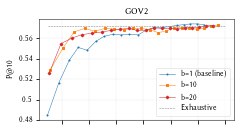

In [108]:
fastnn = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/fast.NN.eval.csv')
fastnn = fastnn.groupby('budget').mean().reset_index()
# fastnp = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/fast.NP.eval.csv')
# fastnp = fastnp.groupby('budget').mean().reset_index()
b10nn = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/batch-b10.csv')
b10nn = b10nn.groupby('budget').mean().reset_index()
# b10np = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/b10.NP.eval.csv')
# b10np = b10np.groupby('budget').mean().reset_index()
# b10pp = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/b10.PP.eval.csv')
# b10pp = b10pp.groupby('budget').mean().reset_index()
b20nn = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/batch-b20.csv')
b20nn = b20nn.groupby('budget').mean().reset_index()

# plt.plot(fastgonn['pcfrac'], fastgonn['p10'], label='B=1 FAST + global ordering')
plt.plot(fastnn['postingcost'], fastnn['p10'], '.-', color=colors[0], label='b=1 (baseline)', markersize=2)
# plt.plot(fastnp['postingcost'], fastnp['p10'], '.--', label='B=1 FAST SEL=P')
plt.plot(b10nn['postingcost'], b10nn['p10'], 's-', color=colors[1], label='b=10', markersize=2)
# plt.plot(b10np['postingcost'], b10np['p10'], 'o--', label='B=10 FAST SEL=P')
# plt.plot(b10pp['postingcost'], b10pp['p10'], 'o:', label='B=10 FAST TRAIN=P SEL=P')
plt.plot(b20nn['postingcost'], b20nn['p10'], 'D-', color=colors[3], label='b=20', markersize=2)
# plt.plot(b10gonn['pcfrac'], b10gonn['p10'], label='B=10 FAST + global ord. feature')
plt.plot([100, 1400], [0.5718] * 2, '--', color='tab:gray', label='Exhaustive', markersize=2)
plt.legend()
plt.title('GOV2', fontsize=9)
# plt.xlabel(r'Posting Cost [$\times 10^6$]')
plt.ylabel('P@10')
xticks = [200, 400, 600, 800, 1000, 1200, 1400]
yticks = [0.48, 0.5, 0.52, 0.54, 0.56]
plt.xticks(xticks, [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4], fontsize=8)
plt.xticks(xticks, [], fontsize=8)
plt.yticks(yticks, yticks, fontsize=8)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2, left=0.15, top=0.9)
fig.set_size_inches((3.3, 2))
plt.savefig('/home/michal/export/gov2-p10.pdf')
plt.show()

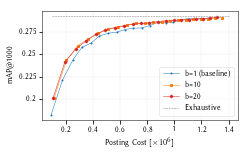

In [105]:
plt.plot(fastnn['postingcost'], fastnn['map'], '.-', color=colors[0], label='b=1 (baseline)', markersize=2)
plt.plot(b10nn['postingcost'], b10nn['map'], 's-', color=colors[1], label='b=10', markersize=2)
plt.plot(b20nn['postingcost'], b20nn['map'], 'D-', color=colors[3], label='b=20', markersize=2)
plt.plot([100, 1400], [0.2927] * 2, '--', color='tab:gray', label='Exhaustive', markersize=2)
plt.legend()
# plt.title('GOV2', fontsize=9)
plt.xlabel(r'Posting Cost [$\times 10^6$]')
plt.ylabel('mAP@1000')
xticks = [200, 400, 600, 800, 1000, 1200, 1400]
yticks = [0.2, 0.225, 0.25, 0.275]
plt.xticks(xticks, [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4], fontsize=8)
plt.yticks(yticks, yticks, fontsize=8)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2, left=0.15)
fig.set_size_inches((3.3, 2))
plt.savefig('/home/michal/export/gov2-map.pdf')
plt.show()

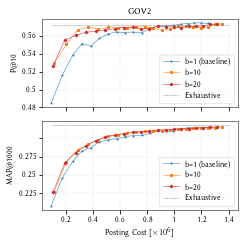

In [143]:
fastnn = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/fast.NN.eval.csv')
fastnn = fastnn.groupby('budget').mean().reset_index()
b10nn = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/batch-b10.csv')
b10nn = b10nn.groupby('budget').mean().reset_index()
b20nn = pd.read_csv('/data/michal/experiments/oss/gov2-dai/eval/batch-b20.csv')
b20nn = b20nn.groupby('budget').mean().reset_index()

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(fastnn['postingcost'], fastnn['p10'], '.-', color=colors[0], label='b=1 (baseline)', markersize=2)
ax1.plot(b10nn['postingcost'], b10nn['p10'], 's-', color=colors[1], label='b=10', markersize=2)
ax1.plot(b20nn['postingcost'], b20nn['p10'], 'D-', color=colors[3], label='b=20', markersize=2)
ax1.plot([100, 1400], [0.5718] * 2, '--', color='tab:gray', label='Exhaustive', markersize=2)
ax1.legend()
ax1.set_title('GOV2', fontsize=9)
# plt.xlabel(r'Posting Cost [$\times 10^6$]')
ax1.set_ylabel('P@10')
yticks = [0.48, 0.5, 0.52, 0.54, 0.56]
ax1.set_yticklabels(yticks, fontsize=8)

ax2.plot(fastnn['postingcost'], fastnn['map'], '.-', color=colors[0], label='b=1 (baseline)', markersize=2)
ax2.plot(b10nn['postingcost'], b10nn['map'], 's-', color=colors[1], label='b=10', markersize=2)
ax2.plot(b20nn['postingcost'], b20nn['map'], 'D-', color=colors[3], label='b=20', markersize=2)
ax2.plot([100, 1400], [0.2927] * 2, '--', color='tab:gray', label='Exhaustive', markersize=2)
ax2.legend()
# plt.title('GOV2', fontsize=9)
ax2.set_xlabel(r'Posting Cost [$\times 10^6$]')
ax2.set_ylabel('MAP@1000')
xticks = [200, 400, 600, 800, 1000, 1200, 1400]
yticks = [0.2, 0.225, 0.25, 0.275]
plt.xticks(xticks, [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4], fontsize=8)
ax2.set_yticklabels(yticks, fontsize=8)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches((3.3, 3.3))
fig.subplots_adjust(left=0.15)
plt.savefig('/home/michal/export/gov2-precmap.pdf')
plt.show()

In [14]:
b10_shards = []
b20_shards = []
b10_std = []
b20_std = []
for budget in range(10, 201, 10):
    sel = pd.read_csv(f'/data/michal/experiments/oss/gov2-dai/eval/results/b10N/selectionsN{budget}.0.csv')
    b10_shards.append(sel.groupby('query')['shard'].nunique().mean())
    b10_std.append(sel.groupby('query')['shard'].nunique().std())
    sel = pd.read_csv(f'/data/michal/experiments/oss/gov2-dai/eval/results/b20N/selectionsN{budget * 2}.0.csv')
    b20_shards.append(sel.groupby('query')['shard'].nunique().mean())
    b20_std.append(sel.groupby('query')['shard'].nunique().std())
means = pd.DataFrame({'b10': b10_shards, 'b1': range(1, 21), 'b20': b20_shards})
std = pd.DataFrame({'b10': b10_std, 'b1': 0, 'b20': b20_std})

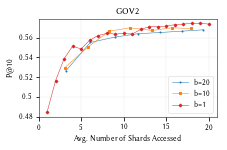

In [90]:
accessed_b20 = pd.DataFrame({
    'p10': b20nn['p10'],
    'map': b20nn['map'],
    'shards': means['b20']
}).where(lambda df: df['shards'] <= 20)
accessed_b10 = pd.DataFrame({
    'p10': b10nn['p10'],
    'map': b10nn['map'],
    'shards': means['b10']
}).where(lambda df: df['shards'] <= 20)
plt.plot(accessed_b20['shards'], accessed_b20['p10'], '.-', color=colors[0], label='b=20', markersize=2)
plt.plot(accessed_b10['shards'], accessed_b10['p10'], 's-', color=colors[1], label='b=10', markersize=2)
plt.plot(means['b1'], fastnn['p10'], 'D-', color=colors[3], label='b=1', markersize=2)
plt.legend()
plt.title('GOV2', fontsize=9)
plt.xlabel('Avg. Number of Shards Accessed')
plt.ylabel('P@10')
xticks = [0, 5, 10, 15, 20]
yticks = [0.48, 0.5, 0.52, 0.54, 0.56]
plt.xticks(xticks, xticks, fontsize=8)
plt.yticks(yticks, yticks, fontsize=8)
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2, left=0.15)
fig.set_size_inches((3.3, 2))
plt.savefig('/home/michal/export/gov2-p10-shards.pdf')
plt.show()

In [89]:
plt.plot(accessed_b20['shards'], accessed_b20['map'], '.-', color=colors[0], label='b=20', markersize=2)
plt.plot(accessed_b10['shards'], accessed_b10['map'], 's-', color=colors[1], label='b=10', markersize=2)
plt.plot(means['b1'], fastnn['map'], 'D-', color=colors[3], label='b=1', markersize=2)
plt.legend()
plt.title('GOV2', fontsize=9)
plt.xlabel('Avg. Number of Shards Accessed')
plt.ylabel('mAP')
xticks = [0, 5, 10, 15, 20]
yticks = [0.48, 0.5, 0.52, 0.54, 0.56]
# plt.xticks(xticks, xticks, fontsize=8)
# plt.yticks(yticks, yticks, fontsize=8)
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2, left=0.15)
fig.set_size_inches((3.3, 2))
plt.savefig('/home/michal/export/gov2-map-shards.pdf')
plt.show()

NameError: name 'accessed_b20' is not defined

In [91]:
pq.read_table('/data/michal/experiments/oss/gov2-dai/features/trec/gov2-trec_eval-queries-OR.txt.trecres-10.0').to_pandas()

,query,shard,bucket,rank,score,title
0,701,0,0,0,12.597461,GX078-85-3427951
1,701,0,0,1,12.034784,GX006-36-16549530
2,701,0,0,2,11.983892,GX048-46-11448216
3,701,0,0,3,11.936883,GX250-16-8785330
4,701,0,0,4,11.907037,GX011-52-9841480
5,701,0,0,5,11.865723,GX042-41-7987176
6,701,0,0,6,11.854050,GX018-85-0462032
7,701,0,0,7,11.813506,GX049-50-0544990
8,701,0,0,8,11.462587,GX230-43-4889594
9,701,0,0,9,11.401383,GX257-64-12332246


In [92]:
pq.read_table('/data/michal/experiments/oss/gov2-dai/features/trec/gov2-trec_eval-queries-OR.txt#0.results-10').to_pandas()

,query,rank,ldocid,gdocid,score,shard,bucket
0,0,0,2675,536393,12.597461,0,0
1,0,1,2352,492115,12.034784,0,0
2,0,2,3238,602038,11.983892,0,0
3,0,3,2971,570641,11.936883,0,0
4,0,4,1980,431898,11.907037,0,0
5,0,5,2630,530651,11.865723,0,0
6,0,6,1242,313003,11.854050,0,0
7,0,7,1564,361694,11.813506,0,0
8,0,8,1999,435563,11.462587,0,0
9,0,9,206,66671,11.401383,0,0


In [76]:
cw_b10nn = pd.read_csv('/data/michal/experiments/oss/cw09b-dai/eval/batch-b10.csv')
cw_b10nn = cw_b10nn.groupby('budget').mean().reset_index()
cw_b20nn = pd.read_csv('/data/michal/experiments/oss/cw09b-dai/eval/batch-b20.csv')
cw_b20nn = cw_b20nn[(cw_b20nn['budget'] < 401) & (cw_b20nn['budget'] > 18)].groupby('budget').mean().reset_index()
cw_b10_shards = []
cw_b20_shards = []
for budget in range(10, 201, 10):
    sel = pd.read_csv(f'/data/michal/experiments/oss/cw09b-dai/eval/results/b10N/selectionsN{budget}.0.csv')
    cw_b10_shards.append(sel.groupby('query')['shard'].nunique().mean())
    sel = pd.read_csv(f'/data/michal/experiments/oss/cw09b-dai/eval/results/b20N/selectionsN{budget * 2}.0.csv')
    cw_b20_shards.append(sel.groupby('query')['shard'].nunique().mean())
cw_means = pd.DataFrame({'b10': cw_b10_shards, 'b1': range(1, 21), 'b20': cw_b20_shards})

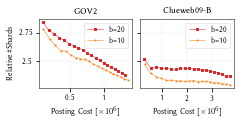

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(b20nn['postingcost'], means['b20'] / means['b1'], 's-', color=colors[3], label='b=20', markersize=2)
ax1.plot(b10nn['postingcost'], means['b10'] / means['b1'], '.-', color=colors[1], label='b=10', markersize=2)
# ax1.plot(fastnn['budget'], means['b1'], 's-', color=colors[0], label='b=10', markersize=2)
ax2.plot(cw_b20nn['postingcost'], cw_means['b20'] / cw_means['b1'], 's-', color=colors[3], label='b=20', markersize=2)
ax2.plot(cw_b10nn['postingcost'], cw_means['b10'] / cw_means['b1'], '.-', color=colors[1], label='b=10', markersize=2)
# ax2.plot(fastnn['budget'], means['b1'], 's-', color=colors[0], label='b=10', markersize=2)
# # plt.plot(means['b1'], fastnn['map'], 'D-', color=colors[3], label='b=1', markersize=2)
ax1.legend()
ax2.legend()
ax1.set_title('GOV2', fontsize=9)
ax2.set_title('Clueweb09-B', fontsize=9)
ax1.set_ylabel('Relative \#Shards')
ax1.set_xlabel(r'Posting Cost [$\times 10^6$]')
ax2.set_xlabel(r'Posting Cost [$\times 10^6$]')
xticks = [0, 10, 20]
yticks = [2.25, 2.50, 2.75, 3.00, 3.25]
ax1.set_xticklabels([0, 0.5, 1], fontsize=8)
ax1.set_yticklabels(yticks, fontsize=8)
ax2.set_xticklabels([0, 1, 2, 3], fontsize=8)
fig.tight_layout()
fig.set_size_inches((3.3, 1.6))
fig.subplots_adjust(bottom=0.25, left=0.15, top=0.85)
plt.savefig('/home/michal/export/shards.pdf')
plt.show()

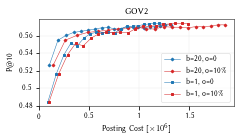

In [133]:
b20nn['pco_1000'] = b20nn['postingcost'] + means['b20'] * 0
b20nn['pco_5000'] = b20nn['postingcost'] + means['b20'] * 1.2
b20nn['pco_10000'] = b20nn['postingcost'] + means['b20'] * 12
plt.plot(b20nn['pco_1000'], b20nn['p10'], 'D-', color=colors[0], label='b=20, o=0', markersize=2)
# plt.plot(b20_nn['pco_5000'], b20_nn['p10'], 'D-', color=colors[1], label='b=20, o=10k', markersize=2)
plt.plot(b20nn['pco_10000'], b20nn['p10'], 'D-', color=colors[3], label='b=20, o=10\%', markersize=2)
fastnn['pco_1000'] = fastnn['postingcost'] + means['b1'] * 0
fastnn['pco_5000'] = fastnn['postingcost'] + means['b1'] * 1.2
fastnn['pco_10000'] = fastnn['postingcost'] + means['b1'] * 12
plt.plot(fastnn['pco_1000'], fastnn['p10'], 's-', color=colors[0], label='b=1, o=0', markersize=2)
# plt.plot(nn['pco_5000'], nn['p10'], 's-', color=colors[1], label='b=1, o=10k', markersize=2)
plt.plot(fastnn['pco_10000'], fastnn['p10'], 's-', color=colors[3], label='b=1, o=10\%', markersize=2)
# plt.plot([0, 3750], [0.3222] * 2, '--', color='tab:gray', label='Exhaustive')
plt.legend()
plt.title('GOV2', fontsize=9)
plt.xlabel(r'Posting Cost [$\times 10^6$]')
plt.ylabel('P@10')
# plt.xlim(0, 1000)
xticks = [0, 500, 1000, 1500]
yticks = [0.48, 0.5, 0.52, 0.54, 0.56]
plt.xticks(xticks, [0, 0.5, 1, 1.5], fontsize=8)
plt.yticks(yticks, yticks, fontsize=8)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(bottom=0.25, left=0.15, top=0.85)
fig.set_size_inches((3.3, 2))
plt.savefig('/home/michal/export/gov2-overhead.pdf')
plt.show()